In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('car.data')
print(data.shape)
print(data.columns)

(1727, 7)
Index(['vhigh', 'vhigh.1', '2', '2.1', 'small', 'low', 'unacc'], dtype='object')


In [3]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data.columns = col_names
data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [4]:
new_data = pd.get_dummies(data, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])
X = new_data.drop('class', axis=1).astype(int)
Y = new_data['class'].replace({'unacc': 0, 'acc': 1, 'good':2, 'vgood':3})
print(X.shape)
print(Y.shape)
dataset = pd.concat([X, Y], axis=1)

(1727, 21)
(1727,)


In [5]:
def train_test_split(data, test_size = 0.2):
    num_samples = len(data)
    num_train_samples = int(num_samples * (1 - test_size))
    num_test_samples = num_samples - num_train_samples

    # Split the dataset
    train_data = data.iloc[:num_train_samples]
    test_data = data.iloc[num_train_samples:]

    # Extract features and target for training and testing sets
    X_train = train_data.iloc[:, :-1].values
    y_train = train_data.iloc[:, -1].values
    X_test = test_data.iloc[:, :-1].values
    y_test = test_data.iloc[:, -1].values

    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset, test_size = 0.2)

In [7]:
class MultinomialNaiveBayes:
    def __init__(self):
        self.class_prior = None
        self.feature_likelihood = None
        self.num_classes = 4

    def fit(self, X_train, y_train, alpha=1.0):
        """
        Fit the Naive Bayes classifier to the training data.

        Parameters:
        X_train (numpy.ndarray): The training features.
        y_train (numpy.ndarray): The training labels.
        alpha (float): Smoothing parameter (default is 1.0 for Laplace smoothing).
        """
        num_samples, num_features = X_train.shape
        self.num_classes = np.max(y_train) + 1
        self.class_prior = np.zeros(self.num_classes)
        self.feature_likelihood = np.zeros((self.num_classes, num_features))

        # Calculate class prior probabilities
        for c in range(self.num_classes):
            self.class_prior[c] = np.sum(y_train == c) / num_samples

        # Calculate feature likelihoods
        for c in range(self.num_classes):
            class_samples = X_train[y_train == c]
            total_count = np.sum(class_samples) + alpha * num_features  # Laplace smoothing
            self.feature_likelihood[c] = (np.sum(class_samples, axis=0) + alpha) / total_count

    def predict(self, X_test):
        """
        Predict the class labels for the test data.

        Parameters:
        X_test (numpy.ndarray): The test features.

        Returns:
        numpy.ndarray: Predicted class labels.
        """
        num_samples, num_features = X_test.shape
        predictions = np.zeros(num_samples, dtype=int)

        # Calculate posterior probabilities for each sample
        for i in range(num_samples):
            posteriors = np.zeros(self.num_classes)
            for c in range(self.num_classes):
                posterior = np.log(self.class_prior[c]) + np.sum(np.log(self.feature_likelihood[c][X_test[i] > 0]))
                posteriors[c] = posterior
            predictions[i] = np.argmax(posteriors)

        return predictions
nb_classifier = MultinomialNaiveBayes()
nb_classifier.fit(X_train, y_train)

# Predict
prediction = nb_classifier.predict(X_test)

In [8]:
def compute_metrics(y_true, y_pred):
    """
    Compute accuracy, precision, recall, and F1-score.

    Args:
    y_true (numpy.ndarray): The true labels.
    y_pred (numpy.ndarray): The predicted labels.

    Returns:
    dict: Dictionary containing accuracy, precision, recall, and F1-score.
    """
    # Compute accuracy
    accuracy = np.mean(y_true == y_pred)

    # Compute confusion matrix
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))

    # Compute precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Compute recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Compute F1-score
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score}


In [9]:
metrices = compute_metrics(y_test, prediction)
print(metrices)

{'accuracy': 0.6763005780346821, 'precision': 0.95, 'recall': 0.6031746031746031, 'f1_score': 0.7378640776699029}


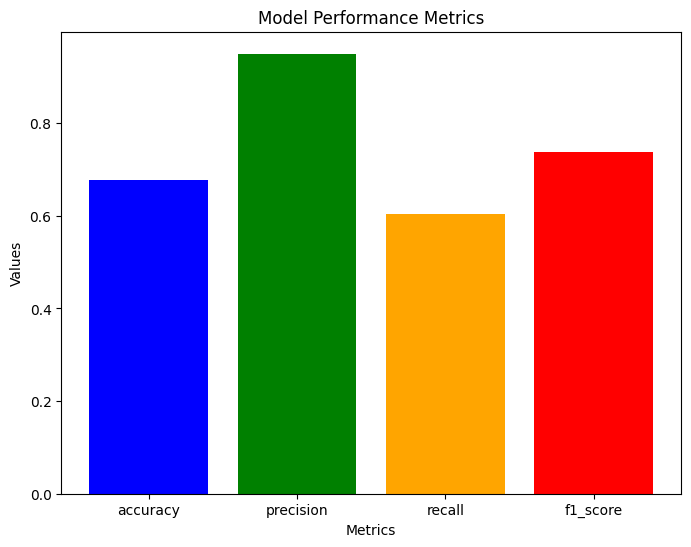

In [10]:
def plot_metrics(metrics):
    """
    Plot the metrics.

    Args:
    metrics (dict): Dictionary containing accuracy, precision, recall, and F1-score.
    """
    labels = list(metrics.keys())
    values = list(metrics.values())

    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Model Performance Metrics')
    plt.savefig('metrics plot.jpg')

# Plot the metrics
plot_metrics(metrices)

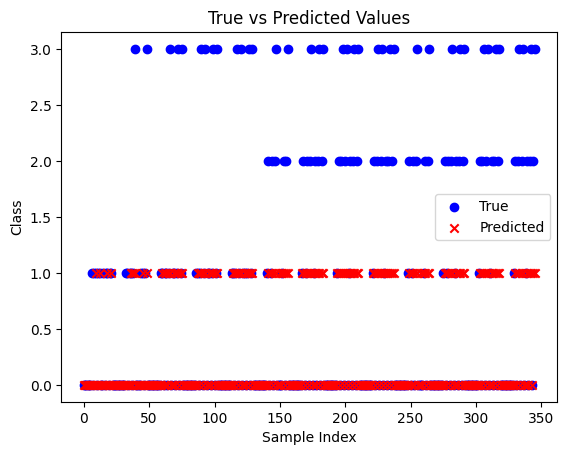

In [12]:
# Plot true values
plt.scatter(range(len(y_test)), y_test, color='blue', label='True', marker='o')

# Plot predicted values
plt.scatter(range(len(prediction)), prediction, color='red', label='Predicted', marker='x')

plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.title('True vs Predicted Values')
plt.legend()
plt.savefig('true vs predicted plot.jpg')